In [2]:
import scipy.io
mat = scipy.io.loadmat('laser.mat') # load mat file
mat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN, Created on: Tue Dec 07 12:35:22 2010',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[29.8509 , 25.7777 , 28.8859 , ...,  9.65777,  5.58567,  9.82632],
        [26.2727 , 31.2289 , 29.7408 , ...,  5.36246,  6.94501,  7.90108],
        [34.179  , 27.0398 , 29.3324 , ..., 14.4956 , 16.8671 , 18.7888 ],
        ...,
        [35.8083 , 31.0808 , 24.7077 , ..., 16.7864 ,  7.77301, 12.6472 ],
        [33.9818 , 27.2921 , 23.285  , ...,  5.35315,  6.88335, -2.805  ],
        [33.3759 , 25.4986 , 31.0451 , ..., 22.5099 , 19.8174 , 20.6888 ]]),
 'Y': array([[-1],
        [ 1],
        [-1],
        [ 1],
        [ 1],
        [ 1],
        [-1],
        [ 1],
        [-1],
        [ 1],
        [-1],
        [ 1],
        [-1],
        [-1],
        [-1],
        [-1],
        [-1],
        [-1],
        [ 1],
        [ 1],
        [-1],
        [-1],
        [ 1],
        [-1],
        [ 1],
        [ 1],
        [-1],
        [-

In [3]:
X = mat['X']
y = mat['Y'].reshape(200) # make y 1-dimensional
print(X.shape)
print(y.shape)

(200, 60)
(200,)


Next it is useful to print some of the data as graphs.

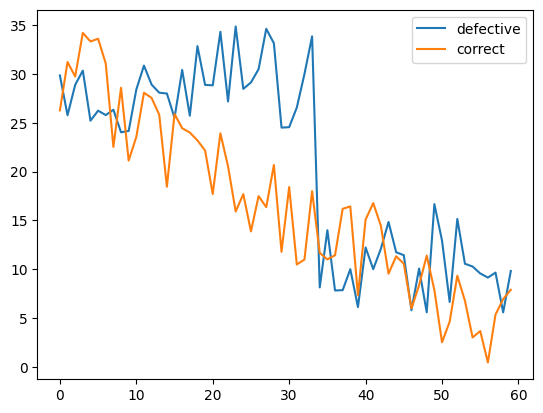

In [4]:
import matplotlib.pyplot as plt
import numpy as np

t = [*range(0, X.shape[1])]
plt.plot(t, X[0], label="defective")
plt.plot(t, X[1], label="correct")
plt.legend()

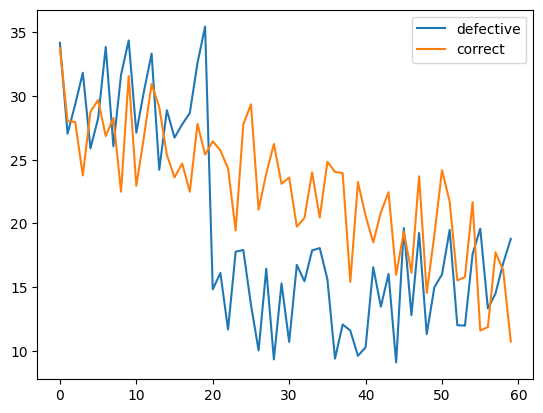

In [5]:
plt.plot(t, X[2], label="defective")
plt.plot(t, X[3], label="correct")
plt.legend()

<b>Split data into training and test</b>

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=0)

print(X_train.shape, X_test.shape)

(130, 60) (70, 60)


## Implement Polynomical and DTW Kernels

<b>DTW Kernel</b>

In [11]:
def d_DTW(x, x2, dist):
    t1, t2 = len(x), len(x2)
    
    #Edge Cases
    if x == [] and x2 == []:
        return 0.0
    elif (x == []) or (x2 == []):
        return np.infty
    
    dp = np.empty((t1+1, t2+1))    
    dp[0, 0] = 0    
    
    for i in range(1, t1+1):
        dp[i, 0] = np.infty
    
    for j in range(1, t2+1):
        dp[0, j] = np.infty
        
    #Standard Procedure
    for i in range(1, t1+1):
        for j in range(1, t2+1):
            dp[i, j] = dist(x[i-1], x2[j-1]) + np.min([dp[i-1, j-1], dp[i-1, j], dp[i, j-1]])
    
    return dp[t1, t2]

<b> Distance Metrics</b>

In [12]:
def d1(x, x2):
    return x != x2

def d2(x, x2):
    return (x-x2)**2

def d3(x, x2):
    return np.abs(x-x2)

def get_dx(x):
    dx = np.zeros(x.shape)
    for i in range(0, len(x)):
        if(i == 0):
            dx[i] = 0
        elif(i == len(x)-1):
            dx[i] = x[i] - x[i-1]
        else:
            dx[i] = 0.5*(x[i]-x[i-1] + (x[i+1] - x[i-1])/2)

    return dx

def d4(x, x2):
    dx = get_dx(x)
    dx2 = get_dx(x2)
    return d2(dx, dx2)

<b>Hyperparameter function</b>

In [13]:
k_hype_dtw = lambda lbd, d: (lambda x, x2: np.exp(-lbd* d_DTW(x, x2, d)))

<b>Kernel Functions with linspace of hyperparameter inputs</b>

In [37]:
def k_stack_dtw(lbd_lin_space):
    stack = []
    for lbd in lbd_lin_space:
        stack.append(k_hype_dtw(lbd, d1))
        stack.append(k_hype_dtw(lbd, d2))
        stack.append(k_hype_dtw(lbd, d3))
    return stack

<b> Kernel </b>

In [18]:
def build_dtw_gram_matrix(xs, x2s, k):
    t1, t2 = len(xs), len(x2s)
    K = np.empty((t1, t2))
    
    for i in range(t1):
        for j in range(i, t2):
            K[i, j] = k(xs[i], x2s[j])
            if i < t2 and j < t1:
                K[j, i] = K[i, j]
        
    return K

In [19]:
def get_dtw_gram_matrix_func(k):
    return (lambda xs, x2s:
        build_dtw_gram_matrix(xs, x2s, k))

<b>Polynomial Kernel</b>

In [79]:
def build_poly_gram_matrix(X1, X2, gamma, p):
    K = np.zeros((X1.shape[0],X2.shape[0]))
    K = (gamma*X1.dot(X2.T))**p
    return K

In [80]:
def get_poly_gram_matrix_func(gamma, p):
    return (lambda X1, X2:
        build_poly_gram_matrix(X1, X2, gamma, p))

<b>Regularizer, Loss Function </b>

In [22]:
def L2_reg(w, lbda):
    return 0.5 * lbda * (np.dot(w.T, w)), lbda*w

def hinge_loss(h, y):
    n = len(h)
    l = np.maximum(0, np.ones(n) - y*h)
    g = -y * (h > 0)
    return l, g

In [68]:
from numpy.linalg import inv

def learn_reg_kernel_ERM(X, y, lbda, K_func, loss=hinge_loss, reg=L2_reg, max_iter=200, tol=0.001, eta=1.):
    g_old = None
    K = K_func(X, X)

    w = np.dot(inv(K + np.dot(np.identity(K.shape[0]), lbda)), y)
    for t in range(max_iter):
        h = np.dot(w, K)
        l,lg = loss(h, y)
            
        r,rg = reg(w, lbda)
        g = lg + rg 
        
        if g_old is not None:
            eta = 0.9**t
            
        w = w - eta*g
        if (np.linalg.norm(eta*g)<tol):
            break
        g_old = g
        
    return w, K


<b> Prediction </b>

In [24]:
def predict(alpha, X, X_2, K_func):
    K = K_func(X_2, X)

    y_pred = np.dot(K, alpha)
    y_pred[y_pred >= 0] = 1
    y_pred[y_pred < 0] = -1
    
    return y_pred

<b>Split list in even parts</b>

In [27]:
def split_list_into_even_parts(list_to_split, num_splits):
    chunk_size = int(len(list_to_split)/num_splits)
    return [list_to_split[i:i+chunk_size] for i in range(0, len(list_to_split), chunk_size)]
    

## Execution

<b>Polynomial</b>

Highest Training Accuracy with gamma 5e-06 and degree 2.0: 1.0
Highest Test Accuracy with gamma 1e-05 and degree 2.0: 0.9428571428571428


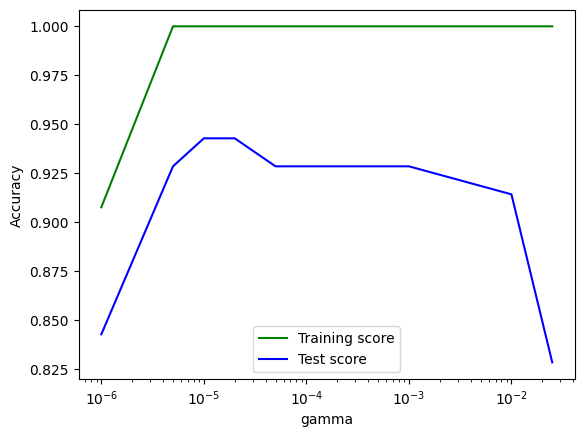

In [95]:
gammas = [g * 0.00001 for g in [0.1, 0.5, 1, 2, 5, 10, 15, 20, 50, 100, 1000, 2500]]
degrees = np.linspace(2,10, 9)

training_accuracies_polynomial = []
test_accuracies_polynomial = []
training_accuracies_polynomial_d_2 = []
test_accuracies_polynomial_d_2 = []

for g in gammas:
    for d in degrees:
        alpha, K = learn_reg_kernel_ERM(X_train, y_train, lbda=0.001, K_func=get_poly_gram_matrix_func(g, d), max_iter=20000, eta=.00000001, tol=.000001)

        y_pred = predict(alpha, X_train, X_train, K_func=get_poly_gram_matrix_func(g, d))
        training_accuracy = np.mean(y_train == y_pred)
        test_accuracy = np.mean(y_test == predict(alpha,X_train, X_test, K_func=get_poly_gram_matrix_func(g, d)))

        training_accuracies_polynomial.append(training_accuracy)
        test_accuracies_polynomial.append(test_accuracy)
        if(d == 2):
            training_accuracies_polynomial_d_2.append(training_accuracy)
            test_accuracies_polynomial_d_2.append(test_accuracy)

max_train_acc = max(training_accuracies_polynomial)
i_best_train_k = training_accuracies_polynomial.index(max_train_acc)
i_best_train_gamma = (int)(i_best_train_k/(len(training_accuracies_polynomial)/len(gammas)))
i_best_train_degree = (int)(i_best_train_k%(len(training_accuracies_polynomial)/len(gammas)))

max_test_acc = max(test_accuracies_polynomial)
i_best_test_k = test_accuracies_polynomial.index(max_test_acc)
i_best_test_gamma = (int)(i_best_test_k/(len(test_accuracies_polynomial)/len(gammas)))
i_best_test_degree = (int)(i_best_test_k%(len(test_accuracies_polynomial)/len(gammas)))

print("Highest Training Accuracy with gamma {} and degree {}: {}".format(gammas[i_best_train_gamma], degrees[i_best_train_degree], max_train_acc))

print("Highest Test Accuracy with gamma {} and degree {}: {}".format(gammas[i_best_test_gamma], degrees[i_best_test_degree], max_test_acc))

plt.plot(gammas, training_accuracies_polynomial_d_2, color="green", label="Training score")
plt.plot(gammas, test_accuracies_polynomial_d_2, color="blue", label="Test score")
plt.xscale("log")
plt.xlabel("gamma")
plt.ylabel("Accuracy")
plt.legend(loc="best")

<b>DTW Kernel</b>

In [38]:
lambdas = [0.1, 1, 5]

k_dtw_list = k_stack_dtw(lambdas)
alpha_stack_dtw = []
K_list_dtw = []

for k in k_dtw_list:
    alpha, K = learn_reg_kernel_ERM(X_train, y_train, lbda=1, K_func=get_dtw_gram_matrix_func(k), max_iter=20000, eta=1, tol=1e-3)
    alpha_stack_dtw.append(alpha)
    K_list_dtw.append(K)

C:\Users\Raphael\AppData\Local\Temp\ipykernel_17464\4247049978.py:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if x == [] and x2 == []:
C:\Users\Raphael\AppData\Local\Temp\ipykernel_17464\4247049978.py:7: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  elif (x == []) or (x2 == []):


In [40]:
training_accuracies_dtw = []
test_accuracies_dtw = []

for i in range(len(alpha_stack_dtw)):
    y_pred = predict(alpha_stack_dtw[i], X_train, X_train, K_func=get_dtw_gram_matrix_func(k_dtw_list[i]))
    training_accuracies_dtw.append(np.mean(y_train == y_pred))
    test_accuracies_dtw.append(np.mean(y_test == predict(alpha,X_train, X_test, K_func=get_dtw_gram_matrix_func(k_dtw_list[i]))))

C:\Users\Raphael\AppData\Local\Temp\ipykernel_17464\4247049978.py:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if x == [] and x2 == []:
C:\Users\Raphael\AppData\Local\Temp\ipykernel_17464\4247049978.py:7: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  elif (x == []) or (x2 == []):


Highest Training Accuracy with index 0: 1.0
Highest Test Accuracy with index 0.8: 0.8


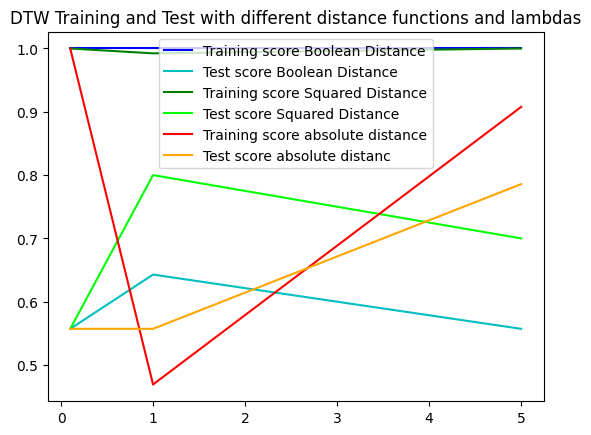

In [61]:
#np.mean(y_test == predict(alpha,X_train, X_test, k2))

max_train_acc = max(training_accuracies_dtw)
print("Highest Training Accuracy with index {}: {}".format(training_accuracies_dtw.index(max_train_acc), max_train_acc))
max_test_acc = max(test_accuracies_dtw)
index_best_dtw = test_accuracies_dtw.index(max_test_acc)
index_best_dtw_lbd = (int)(index_best_dtw/(len(training_accuracies_dtw)/len(lambdas)))
index_best_dtw_distance = (int)(index_best_dtw%(len(training_accuracies_dtw)/len(lambdas)))
print("Highest Test Accuracy with index {}: {}".format(test_accuracies_dtw[index_best_dtw], max_test_acc))

d_training_accuracies = split_list_into_even_parts(training_accuracies_dtw, 3) #split training_accuracies into each d function
d1_training_accuracies = d_training_accuracies[0]
d2_training_accuracies = d_training_accuracies[1]
d3_training_accuracies = d_training_accuracies[2]

d_test_accuracies = split_list_into_even_parts(test_accuracies_dtw, 3) #split test_accuracies into each d function
d1_test_accuracies = d_test_accuracies[0]
d2_test_accuracies = d_test_accuracies[1]
d3_test_accuracies = d_test_accuracies[2]

plt.title("DTW Training and Test with different distance functions and lambdas")
plt.plot(lambdas, d1_training_accuracies, color="b", label="Training score Boolean Distance")
plt.plot(lambdas, d1_test_accuracies, color="c", label="Test score Boolean Distance")
plt.legend(loc="best")

plt.plot(lambdas, d2_training_accuracies, color="g", label="Training score Squared Distance")
plt.plot(lambdas, d2_test_accuracies, color="lime", label="Test score Squared Distance")
plt.legend(loc="best")

plt.plot(lambdas, d3_training_accuracies, color="r", label="Training score absolute distance")
plt.plot(lambdas, d3_test_accuracies, color="orange", label="Test score absolute distanc")
plt.legend(loc="best")

## RandomForest

In [69]:
from sklearn.ensemble import RandomForestClassifier

def get_clf_accuracies(X_train, y_train, X_test, y_test, n_estimators=None, max_depth=None, random_state=0):

    if(n_estimators is not None):
        if(max_depth is not None):
            clf = RandomForestClassifier(n_estimators, max_depth=max_depth, random_state=random_state)
        else:
            clf = RandomForestClassifier(n_estimators, random_state=random_state)
    else:
        if(max_depth is not None):
            clf = RandomForestClassifier(max_depth=max_depth, random_state=random_state)
        else:
            clf = RandomForestClassifier(random_state=random_state)

    clf.fit(X_train, y_train)
    train_values = clf.predict(X_train)
    train_results = []
    train_right = 0
    train_wrong = 0

    for i, y_val in enumerate(y_train):
        if y_val == train_values[i]:
            train_results.append(1)
            train_right += 1
        else:
            train_results.append(0)
            train_wrong += 1

    test_values = clf.predict(X_test)
    test_results = []
    test_right = 0
    test_wrong = 0

    for i, y_val in enumerate(y_test):
        if y_val == test_values[i]:
            test_results.append(1)
            test_right += 1
        else:
            test_results.append(0)
            test_wrong += 1

    return clf, train_right/len(y_train), test_right/len(y_test)

Highest Training Accuracy with index 3: 1.0
Highest Test Accuracy with number of estimators = 32.911357340720215: 0.9857142857142858


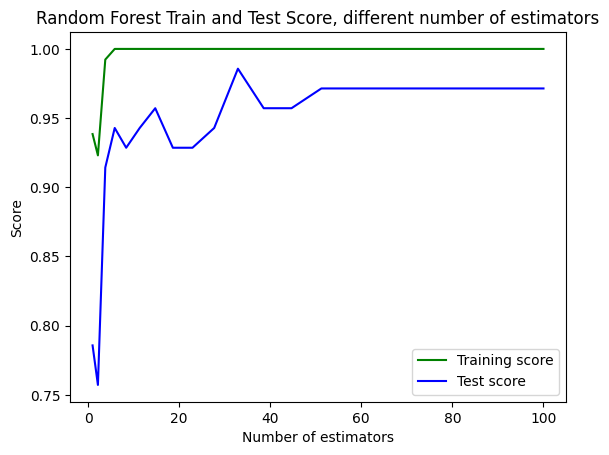

In [72]:
from matplotlib import pyplot as plt

n_estimators = np.linspace(1, 10, num=20)**2

random_forest_classifiers = []
training_accuracies_random_forest = []
test_accuracies_random_forest = []

for n_est in n_estimators:
    clf, train_res, test_res = get_clf_accuracies(X_train, y_train, X_test, y_test, n_estimators=int(n_est))
    random_forest_classifiers.append(clf)
    training_accuracies_random_forest.append(train_res)
    test_accuracies_random_forest.append(test_res)

max_train_acc_rf = max(training_accuracies_random_forest)
print("Highest Training Accuracy with index {}: {}".format(training_accuracies_random_forest.index(max_train_acc_rf), max_train_acc_rf))
max_test_acc_rf = max(test_accuracies_random_forest)
index_best_rf = test_accuracies_random_forest.index(max_test_acc_rf)
print("Highest Test Accuracy with number of estimators = {}: {}".format(n_estimators[index_best_rf], max_test_acc_rf))

plt.plot(n_estimators, training_accuracies_random_forest, color="green", label="Training score")
plt.plot(n_estimators, test_accuracies_random_forest, color="blue", label="Test score")
plt.title("Random Forest Train and Test Score, different number of estimators")
plt.xlabel("Number of estimators")
plt.ylabel("Score")
plt.legend(loc="best")

In [73]:
from sklearn.model_selection import cross_val_score

print("Random Forest Cross Validation score: {}".format(np.mean(cross_val_score(random_forest_classifiers[index_best_rf], X_train, y_train, cv=None))))

Random Forest Cross Validation score: 0.9384615384615385
